In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset Original

In [ ]:
#Carregar o conjunto de dados
data = pd.read_csv("dataset_final.csv")

#Separar variáveis e target
X = data.drop("malignancy", axis=1)
y = data['malignancy'].replace(-1, 0)

# Dataset Harmonizado

In [ ]:
#Carregar o conjunto de dados
data_har = pd.read_csv("dataset_final_harmonized.csv")

#Separar variáveis e target
X_har = data_har.drop("malignancy", axis=1)
y_har= data_har['malignancy'].replace(-1, 0)

In [ ]:
#Inicialização de dicionários para guardar os resultados
resultados = {}
resultados_har = {}

# Pré-processamento dos dados

No pré-processamento dos dados, escolhemos aplicar o StandardScaler para dados numéricos e o OneHotEncoder para dados categóricos, de forma a garantir que as variáveis estão devidamente normalizadas e aptas para o treino. O StandardScaler foi escolhido em vez do MinMaxScaler porque não é afetado por outliers, proporcionando uma representação mais robusta das variáveis. Desta forma as técnicas utilizadas no pré-processamento visam melhorar a performance do modelo e garantir uma melhor interpretação dos resultados

In [5]:
numerical_columns = X.select_dtypes(exclude=['object']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ]
)

In [ ]:
numerical_columns_har = X_har.select_dtypes(exclude=['object']).columns
categorical_columns_har = X_har.select_dtypes(include=['object']).columns

preprocessor_har = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns_har),
        ('cat', OneHotEncoder(), categorical_columns_har)
    ]
)

# Funções

In [ ]:
def calcular_metricas(y_true_all, y_pred_all, y_prob_all):

    """
    Calcula várias métricas de desempenho para avaliar a qualidade do modelo.

    Parâmetros:
    - y_true_all: Array com os valores reais das classes
    - y_pred_all: Array com as previsões do modelo
    - y_prob_all: Array com as probabilidades preditas para a classe positiva

    Métricas Calculadas:
    - Accuracy: Percentagem de previsões corretas
    - Precision: Percentagem de previsões positivas corretas
    - Recall: Percentagem de casos positivos corretamente identificados 
    - F1 Score: Média harmónica entre precisão e sensibilidade 
    - ROC AUC: Área sob a curva ROC, representando a capacidade do modelo de distinguir entre classes
        
    A função retorna um dicionário com todas estas métricas
    """

    metrics = {
        'accuracy': accuracy_score(y_true_all, y_pred_all),
        'precision': precision_score(y_true_all, y_pred_all),
        'recall': recall_score(y_true_all, y_pred_all),
        'f1_score': f1_score(y_true_all, y_pred_all),
        'roc_auc': roc_auc_score(y_true_all, y_prob_all)
    }
    return metrics

In [ ]:
def plotar_resultados(y_true_all, y_pred_all, y_prob_all):

    """
    Apresenta resultados

    Parâmetros:
    - y_true_all: Array com os valores reais das classes
    - y_pred_all: Array com as previsões do modelo
    - y_prob_all: Array com as probabilidades preditas para a classe positiva

    Funções:
    - Calcula as métricas através da função `calcular_metricas`
    - Exibe o relatório de classificação com métricas detalhadas
    - Faz plot da matriz de confusão
    - Gera e exibe a curva ROC

    Retorna as métricas calculadas
    """

    metrics = calcular_metricas(y_true_all, y_pred_all, y_prob_all)

    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"ROC AUC: {metrics['roc_auc']:.4f}")

    #Relatório de classificação
    print("\nClassification Report:")
    print(classification_report(y_true_all, y_pred_all))

    #Plot da matriz de confusão
    conf_matrix = confusion_matrix(y_true_all, y_pred_all)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
    plt.xlabel('Previsões')
    plt.ylabel('Valores Reais')
    plt.title('Matriz de Confusão')
    plt.show()

    #Calcular e plotar a curva ROC
    fpr, tpr, thresholds = roc_curve(y_true_all, y_prob_all)
    roc_auc = auc(fpr, tpr)

    #Plot da curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    return metrics

In [ ]:
def treino_e_avaliacao_rf(X, y, preprocessor, n_folds):

    """
    Treina e avalia um modelo RandomForestClassifier usando validação cruzada estratificada

    Parâmetros:
    - X: Dados de entrada
    - y: Target
    - preprocessor: Pipeline de pré-processamento dos dados
    - n_folds: Número de divisões para a validação cruzada

    Passos:
    - Divide os dados em `n_folds` utilizando validação cruzada estratificada
    - Para cada divisão, aplica o pré-processamento e treina o classificador Random Forest
    - Armazena as previsões e as probabilidades de previsão para cada instância

    Retorna:
    - Arrays: y_true_all, y_pred_all e y_prob_all
    - Modelos treinados e o pipeline completo
    """

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    y_true_all, y_pred_all, y_prob_all = [], [], []
    models = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier',RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
        ])
        
        pipeline.fit(X_train, y_train)
        models.append(pipeline.named_steps['classifier'])
        
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        
        y_pred_all.extend(y_pred)
        y_prob_all.extend(y_prob)
        y_true_all.extend(y_test)
    
    return np.array(y_true_all), np.array(y_pred_all), np.array(y_prob_all), models, pipeline

In [ ]:
def treino_e_avaliacao(X, y, preprocessor, model, n_folds):

    """
    Treina e avalia um modelo com validação cruzada estratificada e PCA

    Parâmetros:
    - X: Dados de entrada
    - y: Target
    - preprocessor: Pipeline de pré-processamento
    - model: Classificador a ser treinado
    - n_folds: Número de divisões na validação cruzada

    Passos:
    - Executa validação cruzada estratificada
    - Aplica o PCA para reduzir a dimensionalidade dos dados
    - Treina o classificador especificado para cada divisão
    
    Retorna: Os arrays y_true_all, y_pred_all e y_prob_all
    """

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    y_true_all, y_pred_all, y_prob_all = [], [], []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('pca', PCA(n_components=9)),
            ('classifier', model)
        ])
        
        pipeline.fit(X_train, y_train)
        
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        
        y_pred_all.extend(y_pred)
        y_prob_all.extend(y_prob)
        y_true_all.extend(y_test)
    
    return np.array(y_true_all), np.array(y_pred_all), np.array(y_prob_all)

No nosso projeto decidimos utilizar o Stratified K-Folds de forma a garantir que cada fold contém aproximadamente a mesma proporção de cada classe do dataset.


Decidimos aplicar o PCA aos modelo SVM uma vez que ajuda a melhorar a sua performance, pois este é sensível ao ruído e à alta dimensionalidade. 
Aplicamos também ao modelo XGBoost dado que a redução de variáveis irrelevantes diminui o número de nós nas árvores, tornando o modelo mais eficiente.

Assim, conseguimos treinar e testar o modelo em subconjuntos representativos dos dados, o que ajuda na avaliação de desempenho com um maior nível de confiabilidade e reduz o risco de o modelo se sobreajustar à classe maioritária.

# Random Forest

Escolhemos este modelo uma vez que ele combina múltiplas árvores de decisão para melhorar a sua precisão e robustez. O Random Forest captura interações complexas entre variáveis o que é importante considerando a natureza dos nossos dados.

Aplicação do Random Forest ao Dataset Original

RF com 5 folds

Accuracy: 0.7260
Precision: 0.7299
Recall: 0.5789
F1 Score: 0.6457
ROC AUC: 0.7993

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.84      0.78      1262
           1       0.73      0.58      0.65       957

    accuracy                           0.73      2219
   macro avg       0.73      0.71      0.71      2219
weighted avg       0.73      0.73      0.72      2219



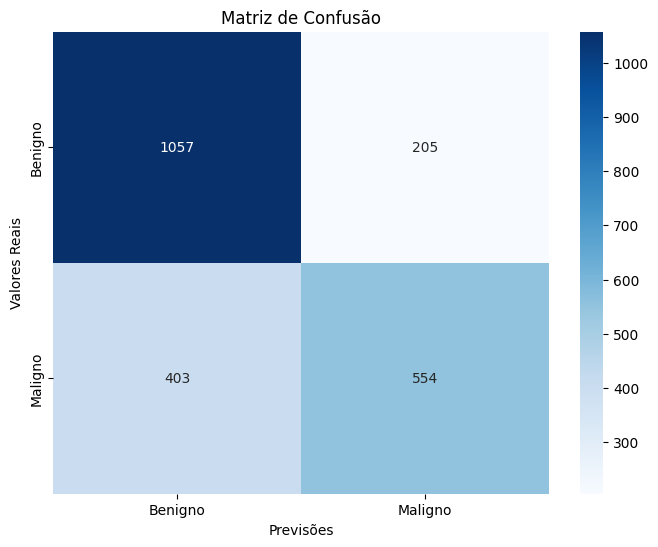

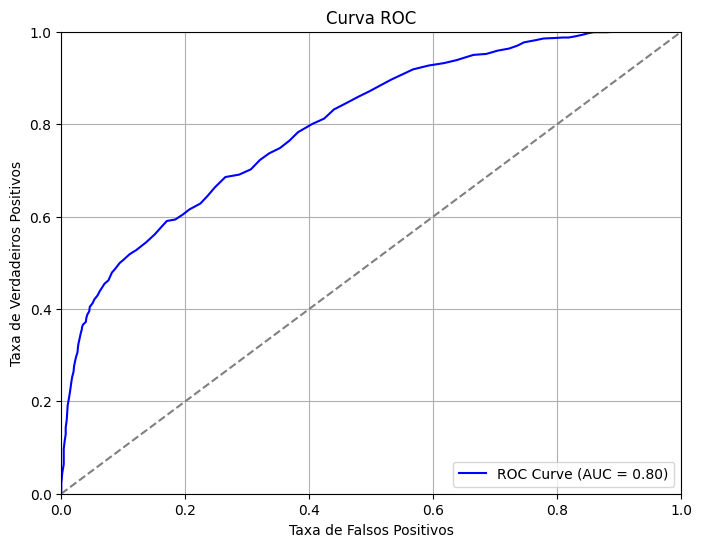

RF com 10 folds

Accuracy: 0.7278
Precision: 0.7363
Recall: 0.5747
F1 Score: 0.6455
ROC AUC: 0.8044

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.84      0.78      1262
           1       0.74      0.57      0.65       957

    accuracy                           0.73      2219
   macro avg       0.73      0.71      0.71      2219
weighted avg       0.73      0.73      0.72      2219



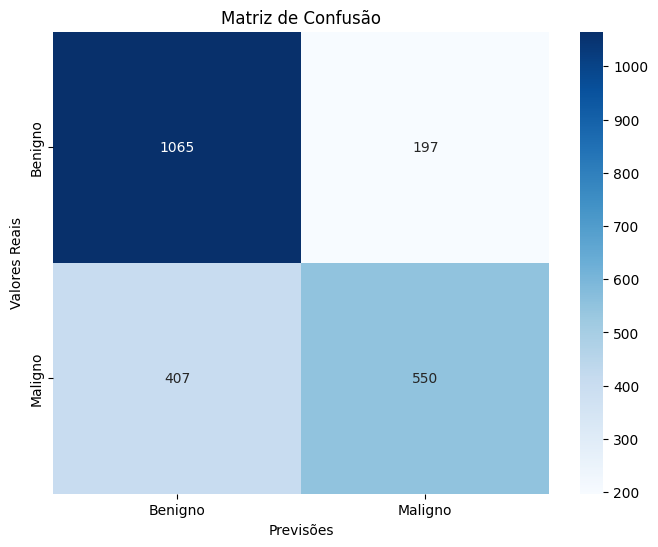

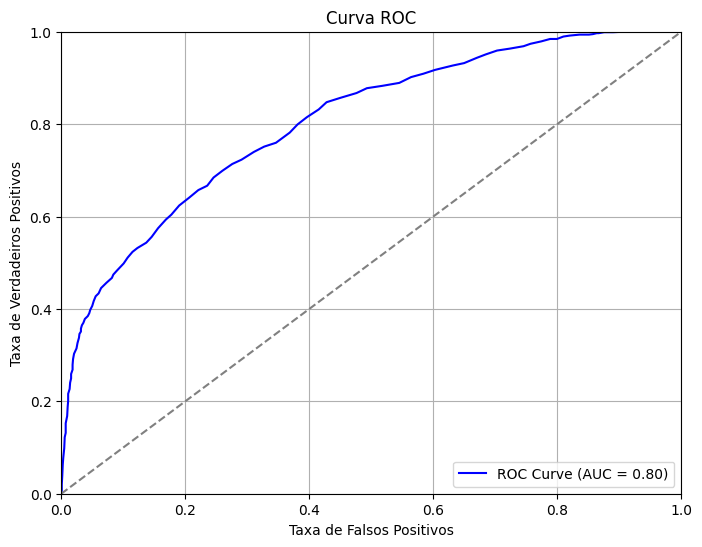

In [12]:
print("RF com 5 folds\n")
y_true, y_pred, y_prob, models_5, pipeline_5= treino_e_avaliacao_rf(X, y, preprocessor, n_folds=5)
resultados['RF_5F'] = plotar_resultados(y_true, y_pred, y_prob)

print("RF com 10 folds\n")
y_true, y_pred, y_prob, models_10, pipeline_10= treino_e_avaliacao_rf(X, y, preprocessor, n_folds=10)
resultados['RF_10F'] = plotar_resultados(y_true, y_pred, y_prob)

Tendo por base os resultados anteriores, podemos concluir que a diferença entre a utilização de 5 e 10 folds não influencia de forma muito significativa os resultados.

Aplicação do Random Forest ao Dataset Harmonizado

RF com 5 folds

Accuracy: 0.7314
Precision: 0.7366
Recall: 0.5873
F1 Score: 0.6535
ROC AUC: 0.8128

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.84      0.78      1262
           1       0.74      0.59      0.65       957

    accuracy                           0.73      2219
   macro avg       0.73      0.71      0.72      2219
weighted avg       0.73      0.73      0.73      2219



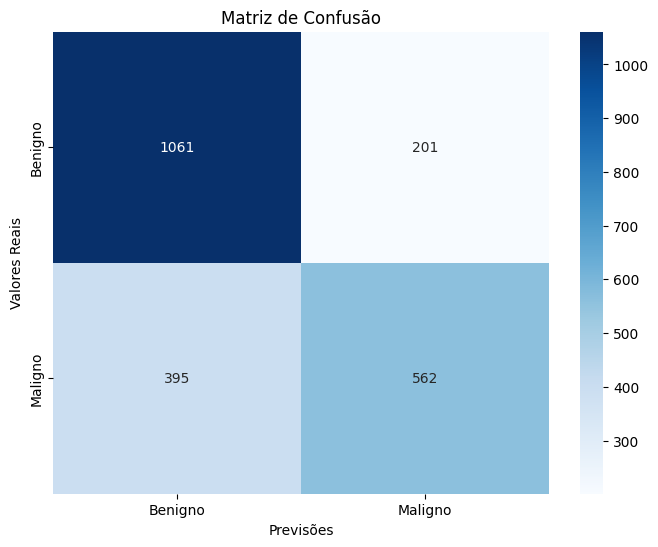

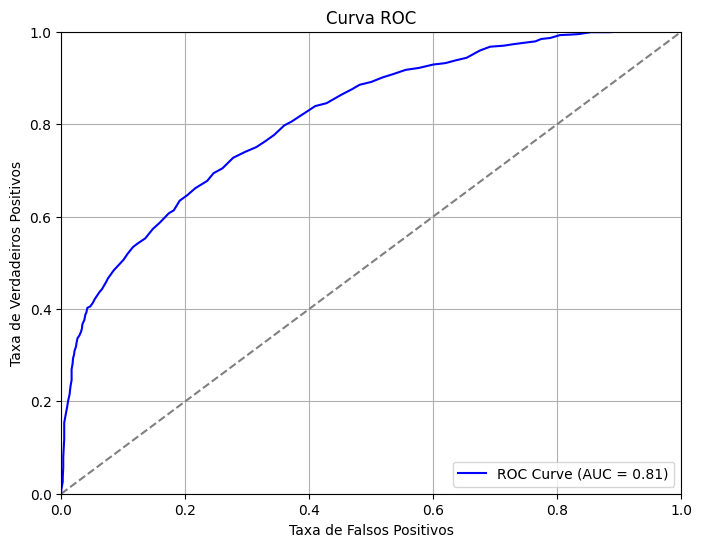

RF com 10 folds

Accuracy: 0.7292
Precision: 0.7354
Recall: 0.5810
F1 Score: 0.6492
ROC AUC: 0.8139

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.84      0.78      1262
           1       0.74      0.58      0.65       957

    accuracy                           0.73      2219
   macro avg       0.73      0.71      0.71      2219
weighted avg       0.73      0.73      0.72      2219



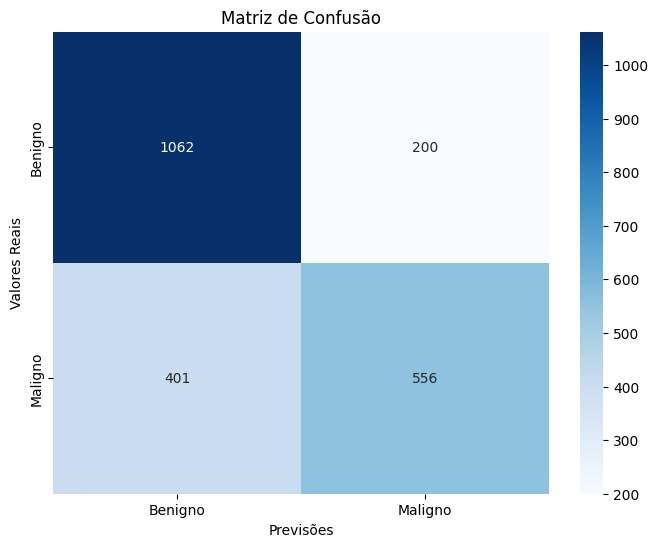

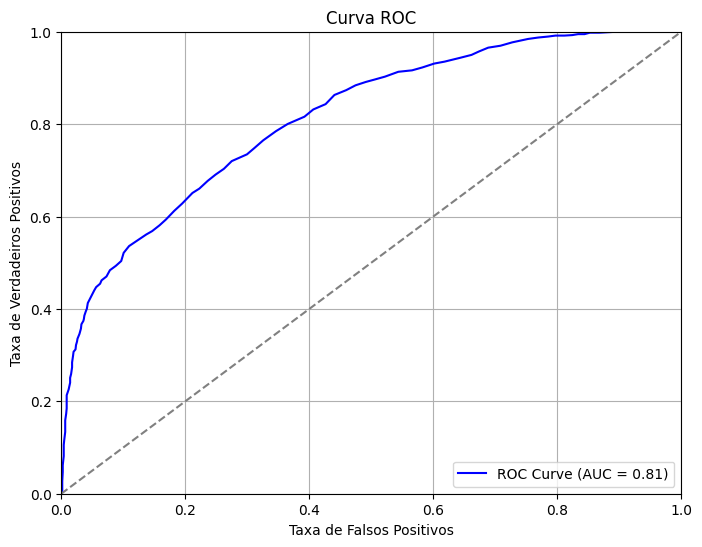

In [13]:
print("RF com 5 folds\n")
y_true_har, y_pred_har, y_prob_har, models_5_har, pipeline_5_har= treino_e_avaliacao_rf(X_har, y_har, preprocessor_har, n_folds=5)
resultados_har['RF_5F'] = plotar_resultados(y_true_har, y_pred_har, y_prob_har)

print("RF com 10 folds\n")
y_true_har, y_pred_har, y_prob_har, models_10_har, pipeline_10_har= treino_e_avaliacao_rf(X_har, y_har, preprocessor_har, n_folds=10)
resultados_har['RF_10F'] = plotar_resultados(y_true_har, y_pred_har, y_prob_har)

Tendo por base os resultados anteriores referentes ao dataset harmonizado, podemos concluir que a diferença entre a utilização de 5 e 10 folds não influencia de forma muito significativa os resultados.

Como a diferença entre 5 e 10 folds foi mínima, decidimos utilizar 10 folds em todos os nossos modelos. 

**Random Forest para o dataset Original**

A utilização do Random Forest para classificar nódulos revelou-se válida, com uma accuracy de 72.78% e uma ROC AUC de 0.8044, o que demonstra uma boa capacidade de separação entre as classes. A precisão de 73.63% é satisfatória, mas o recall de 57.47% sugere que o modelo pode melhorar.

Como podemos observar pela matriz de confusão, existem 407 casos de nódulos Malignos que são erradamente classificados como Benignos assim como 197 Benignos a serem classificados como Malignos. 



**Random Forest para o dataset Harmonizado**

A utilização do Random Forest para classificar nódulos demonstrou ser eficaz, com uma accuracy de 72.92% e uma ROC AUC de 0.8139, refletindo uma boa capacidade de distinção entre as classes. A precisão de 73.54% é positiva, embora o recall de 58.10% indique que o modelo ainda tem espaço para melhorar.

Como podemos observar pela matriz de confusão, existem 401 casos de nódulos Malignos que são erradamente classificados como Benignos assim como 200 Benignos a serem classificados como Malignos. 

# Seleção das features mais significativas a partir do Random Forest

O Random Forest fornece informações sobre a importância de cada variável, o que nos permitiu identificar quais as features que tem maior impacto nas previsões

Escolhemos utilizar o modelo com 10 folds para a extração de features de maneira a garantir uma avaliação mais robusta da sua importância

Importância das features:
                                        Feature  Importance
53                       num__glrlm_RunVariance    0.030153
51  num__glrlm_RunLengthNonUniformityNormalized    0.025450
78                     num__CenterOfMassIndex_x    0.023401
76                          num__CenterOfMass_x    0.021657
19                            num__90Percentile    0.020386
..                                          ...         ...
61   num__glszm_SizeZoneNonUniformityNormalized    0.000071
57            num__glszm_GrayLevelNonUniformity    0.000058
65                       num__glszm_ZoneEntropy    0.000044
67                      num__glszm_ZoneVariance    0.000041
17                 num__Mask-original_VolumeNum    0.000038

[88 rows x 2 columns]


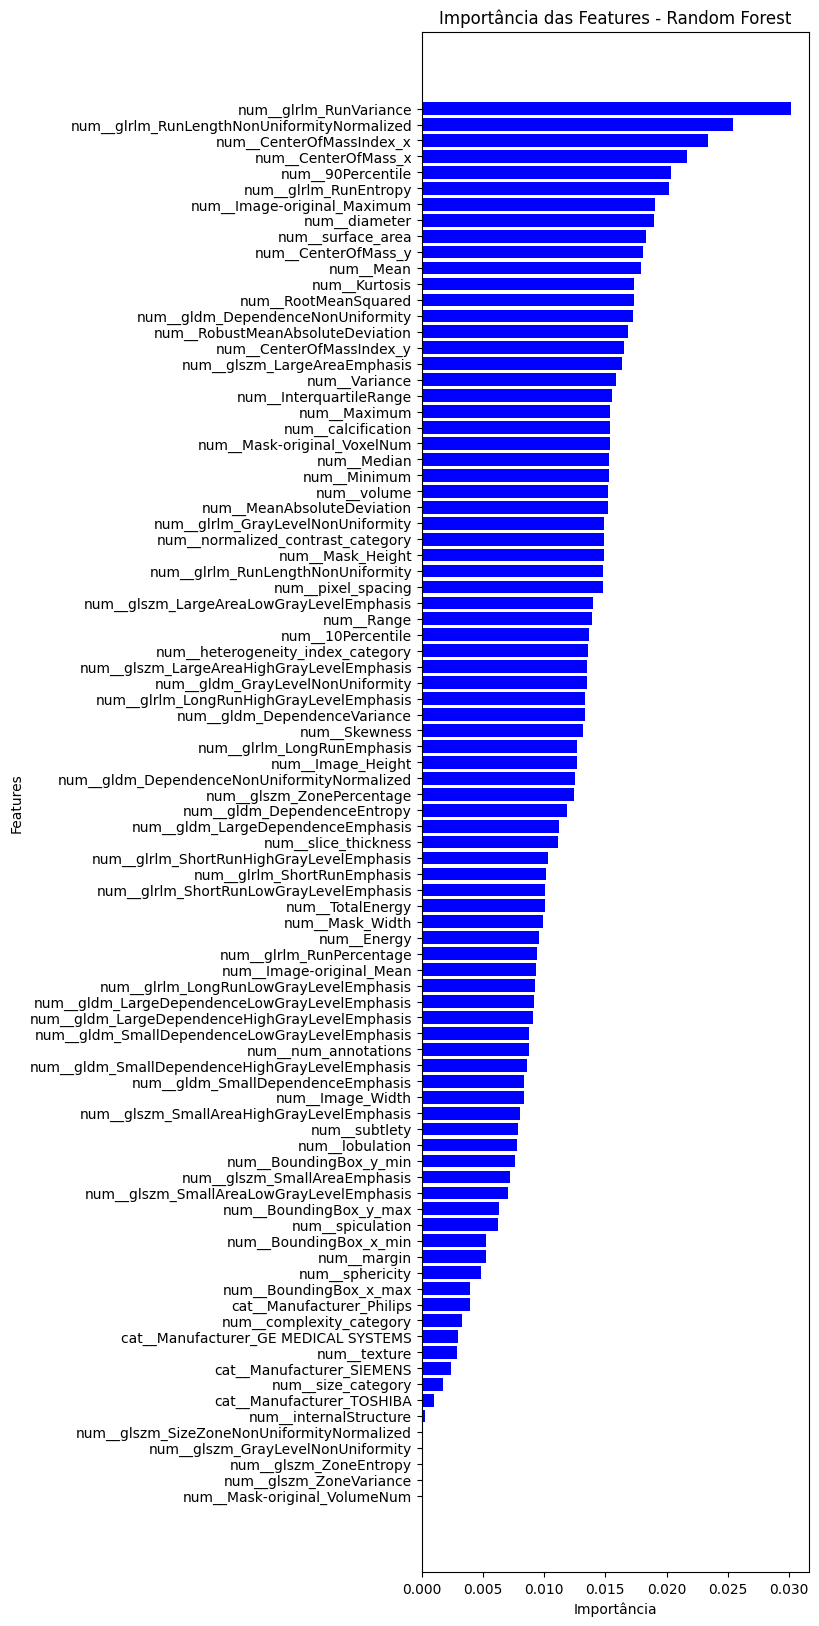

In [ ]:
#Obter nomes das features pós-pré-processamento
feature_names = pipeline_10.named_steps['preprocessor'].get_feature_names_out()

#Calcular a média das importâncias das features ao longo dos folds
feature_importances = np.mean([model.feature_importances_ for model in models_10], axis=0)

#Criar DataFrame com os nomes e importâncias das features
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

#Exibir as importâncias das features
print("Importância das features:")
print(feature_importance_df)

#Visualizar as importâncias em um gráfico
plt.figure(figsize=(5, 20))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='blue')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Importância das Features - Random Forest')
plt.gca().invert_yaxis()
plt.show()

Optamos por escolher as features com importância até 0.01455 pois, como as importâncias variam de 0 a 0.030, este threshold permite-nos focar nas variáveis que impactam significativamente as previsões. Desta forma, asseguramos que apenas as características mais relevantes sejam mantidas.

In [ ]:

threshold = 0.01455 

#Filtrar as features 
important_features = feature_importance_df[feature_importance_df['Importance'] > threshold]
print("Features importantes:")
print(important_features)

Features importantes:
                                        Feature  Importance
53                       num__glrlm_RunVariance    0.030153
51  num__glrlm_RunLengthNonUniformityNormalized    0.025450
78                     num__CenterOfMassIndex_x    0.023401
76                          num__CenterOfMass_x    0.021657
19                            num__90Percentile    0.020386
49                        num__glrlm_RunEntropy    0.020160
15                  num__Image-original_Maximum    0.019062
11                                num__diameter    0.018958
12                            num__surface_area    0.018280
77                          num__CenterOfMass_y    0.018099
25                                    num__Mean    0.017925
22                                num__Kurtosis    0.017320
30                         num__RootMeanSquared    0.017319
35            num__gldm_DependenceNonUniformity    0.017290
29             num__RobustMeanAbsoluteDeviation    0.016880
79                

Repetimos o processo anterior para o modelo Random Forest treinado com o Dataset Harmonizado

Importância das features:
                                       Feature  Importance
65           num__harmonized_glrlm_RunVariance    0.029161
62            num__harmonized_glrlm_RunEntropy    0.024568
80         num__harmonized_CenterOfMassIndex_x    0.022432
78              num__harmonized_CenterOfMass_x    0.021564
11                               num__diameter    0.019935
..                                         ...         ...
4                       num__internalStructure    0.000244
27           num__glszm_GrayLevelNonUniformity    0.000053
32                      num__glszm_ZoneEntropy    0.000051
28  num__glszm_SizeZoneNonUniformityNormalized    0.000049
15                num__Mask-original_VolumeNum    0.000023

[87 rows x 2 columns]


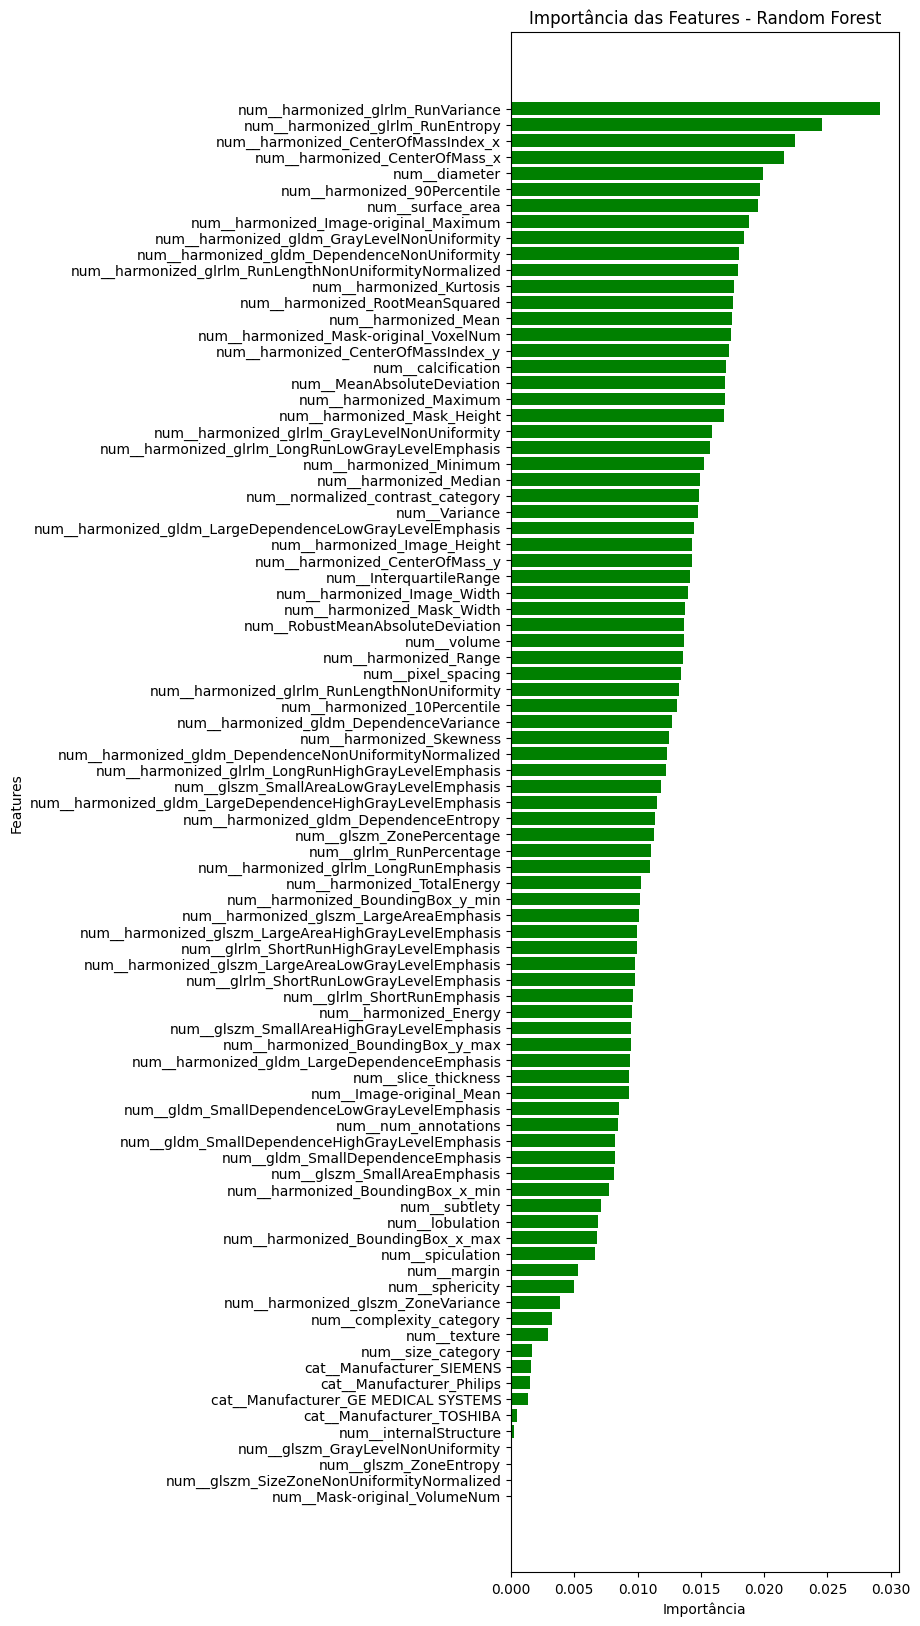

In [ ]:
#Obter nomes das features pós-pré-processamento
feature_names_har = pipeline_10_har.named_steps['preprocessor'].get_feature_names_out()

#Calcular a média das importâncias das features ao longo dos folds
feature_importances_har= np.mean([model.feature_importances_ for model in models_10_har], axis=0)

#Criar DataFrame com os nomes e importâncias das features
feature_importance_har_df = pd.DataFrame({
    'Feature': feature_names_har,
    'Importance': feature_importances_har
}).sort_values(by='Importance', ascending=False)

#Exibir as importâncias das features
print("Importância das features:")
print(feature_importance_har_df)

#Visualizar as importâncias em um gráfico
plt.figure(figsize=(5, 20))
plt.barh(feature_importance_har_df['Feature'], feature_importance_har_df['Importance'], color='green')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Importância das Features - Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
threshold = 0.01455 

#Filtrar as features 
important_features_har = feature_importance_har_df[feature_importance_har_df['Importance'] > threshold]
print("Features importantes:")
print(important_features_har)

Features importantes:
                                              Feature  Importance
65                  num__harmonized_glrlm_RunVariance    0.029161
62                   num__harmonized_glrlm_RunEntropy    0.024568
80                num__harmonized_CenterOfMassIndex_x    0.022432
78                     num__harmonized_CenterOfMass_x    0.021564
11                                      num__diameter    0.019935
39                       num__harmonized_90Percentile    0.019662
12                                  num__surface_area    0.019554
36             num__harmonized_Image-original_Maximum    0.018816
54        num__harmonized_gldm_GrayLevelNonUniformity    0.018431
51       num__harmonized_gldm_DependenceNonUniformity    0.018040
64  num__harmonized_glrlm_RunLengthNonUniformityNo...    0.017971
41                           num__harmonized_Kurtosis    0.017652
47                    num__harmonized_RootMeanSquared    0.017579
43                               num__harmonized_Mean 

# SVM e XGBoost


Decidimos utilizar o SVM dado que é bastante eficaz a encontrar a fronteira ótima que separa as classes e por lidar bem com o ruído.

Decidimos usar o XGBoost por ser eficiente em classificações e por lidar bem com grandes volumes de dados.

Pré-processamento para o dataset original

In [ ]:
#Definir as colunas
selected_columns = ["glrlm_RunVariance","glrlm_RunLengthNonUniformityNormalized","CenterOfMassIndex_x","CenterOfMass_x",
                    "90Percentile","glrlm_RunEntropy", "Image-original_Maximum", "diameter","surface_area","CenterOfMass_y",
                    "Mean","Kurtosis","RootMeanSquared","gldm_DependenceNonUniformity", "RobustMeanAbsoluteDeviation", 
                    "CenterOfMassIndex_y","glszm_LargeAreaEmphasis","Variance","InterquartileRange","Maximum","calcification",
                    "Mask-original_VoxelNum", "Median", "Minimum", "volume", "MeanAbsoluteDeviation", "glrlm_GrayLevelNonUniformity",
                    "normalized_contrast_category", "Mask_Height", "glrlm_RunLengthNonUniformity", "pixel_spacing"
                    ]

#Carregar o conjunto de dados
data = pd.read_csv("dataset_final.csv")

#Separar variáveis
X = data.drop("malignancy", axis=1)
y = data['malignancy'].replace(-1, 0)


#Filtrar X para usar apenas as colunas selecionadas
X = X[selected_columns]

#Identificar colunas categóricas e numéricas
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(exclude=['object']).columns

#Configurar pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ]
)

Pré-processamento para o dataset harmonizado

In [ ]:
#Definir as colunas 
selected_columns_har =  ["harmonized_glrlm_RunVariance", "harmonized_glrlm_RunEntropy", "harmonized_CenterOfMassIndex_x","harmonized_CenterOfMass_x",
                        "diameter","harmonized_90Percentile", "surface_area", "harmonized_Image-original_Maximum", "harmonized_gldm_GrayLevelNonUniformity", 
                        "harmonized_gldm_DependenceNonUniformity","harmonized_glrlm_RunLengthNonUniformityNormalized", "harmonized_Kurtosis", "harmonized_RootMeanSquared",
                        "harmonized_Mean", "harmonized_Mask-original_VoxelNum", "harmonized_CenterOfMassIndex_y", "calcification","MeanAbsoluteDeviation", "harmonized_Maximum", 
                        "harmonized_Mask_Height", "harmonized_glrlm_GrayLevelNonUniformity", "harmonized_glrlm_LongRunLowGrayLevelEmphasis","harmonized_Minimum", 
                        "harmonized_Median", "normalized_contrast_category", "Variance"
                        ]

#Carregar o conjunto de dados
data_har = pd.read_csv("dataset_final_harmonized.csv")

#Separar variáveis 
X_har = data_har.drop("malignancy", axis=1)
y_har= data_har['malignancy'].replace(-1, 0)


#Filtrar X para usar apenas as colunas selecionadas
X_har = X_har[selected_columns_har]

#Identificar colunas categóricas e numéricas
categorical_columns_har = X_har.select_dtypes(include=['object']).columns
numerical_columns_har = X_har.select_dtypes(exclude=['object']).columns

#Configurar pré-processamento
preprocessor_har = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns_har),
        ('cat', OneHotEncoder(), categorical_columns_har)
    ]
)

# SVM e XGBoost  --- Dataset Original

SVM com 10 folds

Accuracy: 0.7242
Precision: 0.6954
Recall: 0.6416
F1 Score: 0.6674
ROC AUC: 0.7961

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      1262
           1       0.70      0.64      0.67       957

    accuracy                           0.72      2219
   macro avg       0.72      0.71      0.72      2219
weighted avg       0.72      0.72      0.72      2219



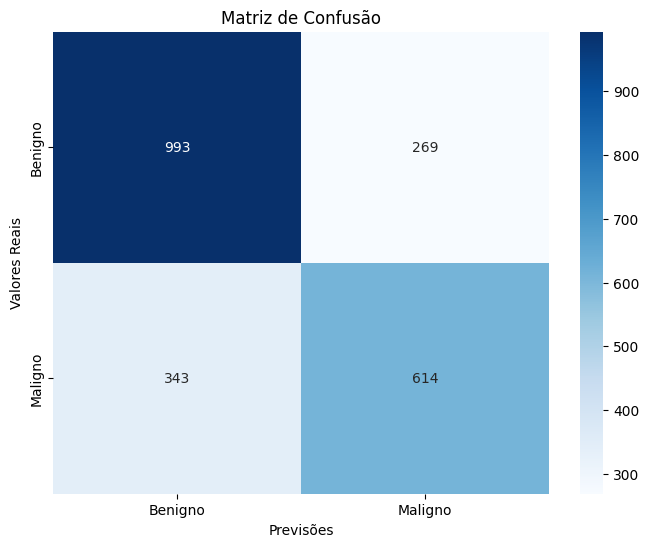

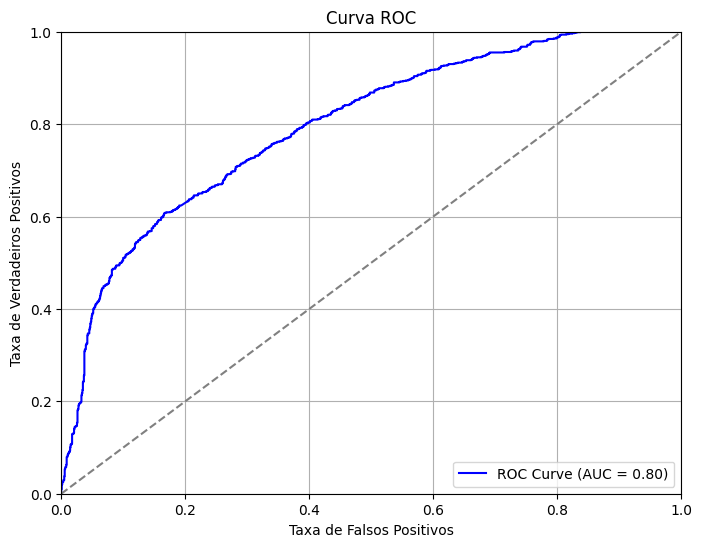

XGBoost com 10 folds

Accuracy: 0.7026
Precision: 0.6634
Recall: 0.6301
F1 Score: 0.6463
ROC AUC: 0.7704

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.74      1262
           1       0.66      0.63      0.65       957

    accuracy                           0.70      2219
   macro avg       0.70      0.69      0.69      2219
weighted avg       0.70      0.70      0.70      2219



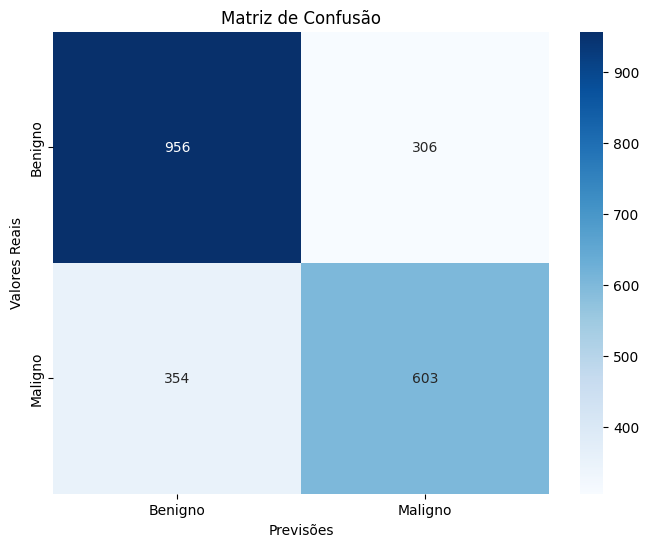

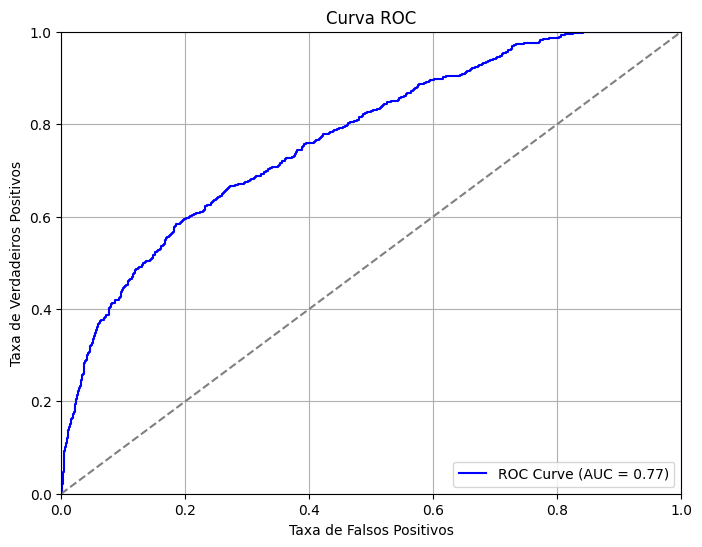

In [36]:
print("SVM com 10 folds\n")
y_true, y_pred, y_prob = treino_e_avaliacao(X, y, preprocessor, model=SVC(kernel='rbf',class_weight='balanced',probability=True), n_folds=10)
resultados['SVM_10F'] = plotar_resultados(y_true, y_pred, y_prob)

print("XGBoost com 10 folds\n")
y_true, y_pred, y_prob = treino_e_avaliacao(X, y, preprocessor, model=XGBClassifier(learning_rate=0.1, n_estimators=1000, eval_metric='logloss'), n_folds=10)
resultados['XGBoost_10F'] = plotar_resultados(y_true, y_pred, y_prob)

**SVM para o Dataset Original**

A utilização do SVM para classificar os nódulos revelou-se uma boa escolha, com uma accuracy de 72,42% e uma ROC AUC de 0,7961. Isto indica uma boa capacidade de discriminação entre classes. Embora a precisão seja de 69.54% e o recall de 64,16%, o modelo mantém um desempenho satisfatório, conseguindo classificar corretamente uma parte significativa dos casos.

Como podemos observar pela matriz de confusão, existem 343 casos de nódulos Malignos que são erradamente classificados como Benignos assim como 269 Benignos a serem classificados como Malignos. 


**XGBoost para o Dataset Original**

A utilização do XGBoost para classificar os nódulos revelou-se válida, com uma accuracy de 70.26% e uma ROC AUC de 0.7704, isto mostra uma capacidade moderada de discriminação entre as classes. O modelo apresenta um recall de 63,01%, refletindo que uma parte significativa dos casos não é identificada corretamente.

Como podemos observar pela matriz de confusão, existem 354 casos de nódulos Malignos que são erradamente classificados como Benignos assim como 306 Benignos a serem classificados como Malignos. 

# SVM e XGBoost --- Dataset Harmonizado

SVM com 10 folds

Accuracy: 0.7274
Precision: 0.7051
Recall: 0.6322
F1 Score: 0.6667
ROC AUC: 0.7985

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      1262
           1       0.71      0.63      0.67       957

    accuracy                           0.73      2219
   macro avg       0.72      0.72      0.72      2219
weighted avg       0.73      0.73      0.73      2219



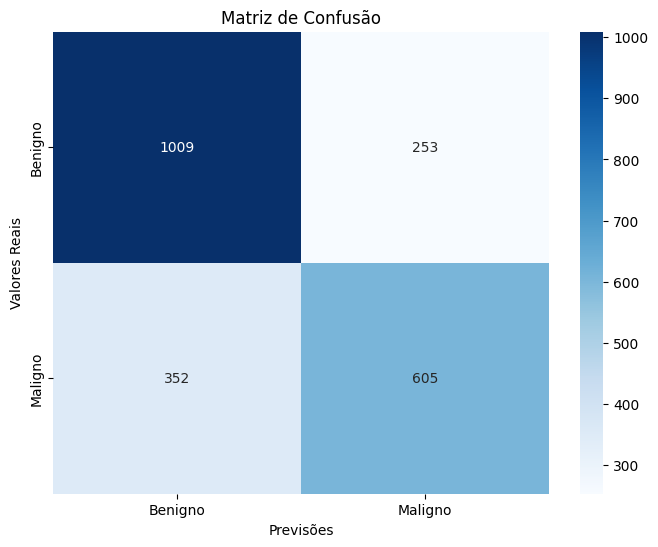

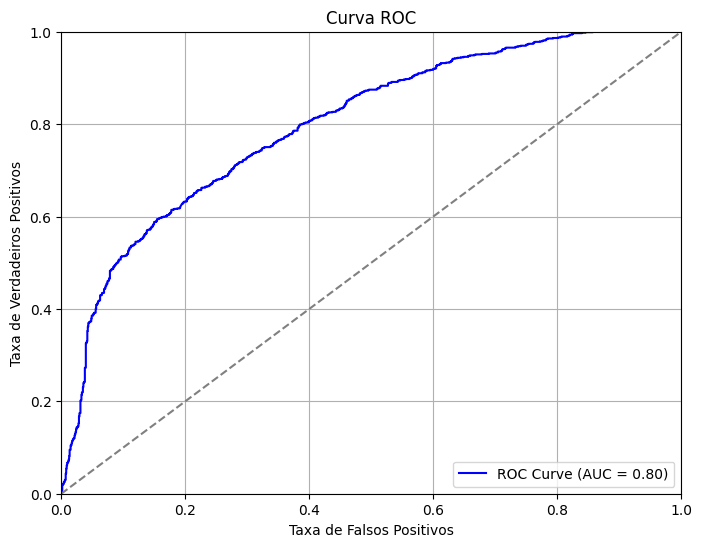

XGBoost com 10 folds

Accuracy: 0.7030
Precision: 0.6693
Recall: 0.6155
F1 Score: 0.6413
ROC AUC: 0.7622

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75      1262
           1       0.67      0.62      0.64       957

    accuracy                           0.70      2219
   macro avg       0.70      0.69      0.69      2219
weighted avg       0.70      0.70      0.70      2219



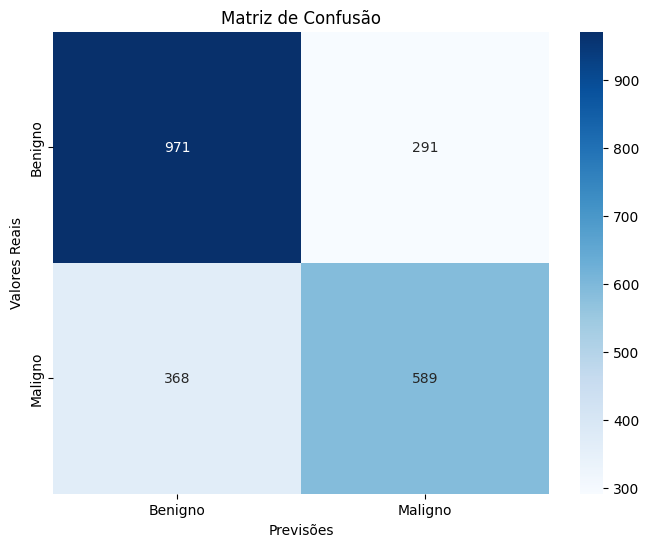

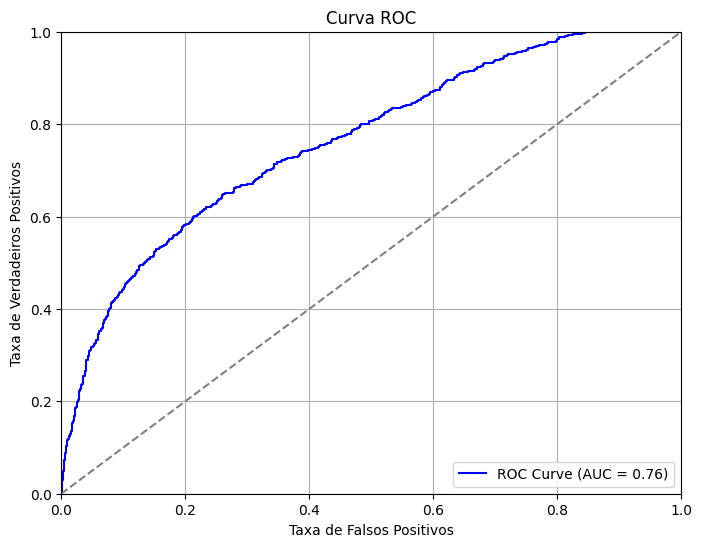

In [38]:
print("SVM com 10 folds\n")
y_true_har, y_pred_har, y_prob_har = treino_e_avaliacao(X_har, y_har, preprocessor_har, model=SVC(kernel='rbf',class_weight='balanced',probability=True), n_folds=10)
resultados_har['SVM_10F'] = plotar_resultados(y_true_har, y_pred_har, y_prob_har)

print("XGBoost com 10 folds\n")
y_true_har, y_pred_har, y_prob_har= treino_e_avaliacao(X_har, y_har, preprocessor_har, model=XGBClassifier(learning_rate=0.1, n_estimators=1000, eval_metric='logloss'), n_folds=10)
resultados_har['XGBoost_10F'] = plotar_resultados(y_true_har, y_pred_har, y_prob_har)

**SVM para o Dataset Harmonizado**

A utilização do SVM para classificar os nódulos mostrou-se uma boa escolha,  com uma accuracy de 72.74% e uma ROC AUC de 0.7985, o que revela uma boa capacidade de distinção entre as classes. A precisão de 70.51% e o recall de 63.22% indicam que, apesar de uma identificação aceitável dos casos, ainda há margem para melhorias

Como podemos observar pela matriz de confusão, existem 352 casos de nódulos Malignos que são erradamente classificados como Benignos assim como 253 Benignos a serem classificados como Malignos. 

**XGBoost para o Dataset Harmonizado**

A utilização do XGBoost para classificar os nódulos mostrou se adequada, com uma accuracy de 70.30% e uma ROC AUC de 0.7622, o que indica uma capacidade moderada de separação entre as classes. A precisão de 66.93% e o recall de 61.55% refletem um desempenho aceitável, embora haja espaço para melhorar a identificação de casos

Como podemos observar pela matriz de confusão, existem 368 casos de nódulos Malignos que são erradamente classificados como Benignos assim como 291 Benignos a serem classificados como Malignos. 

# Visualização dos Resultados

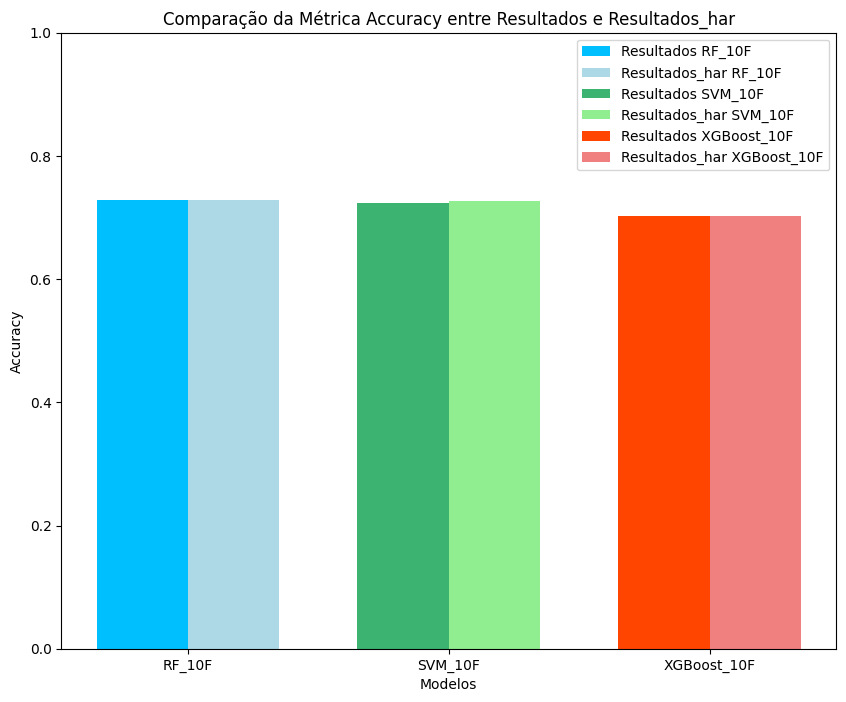

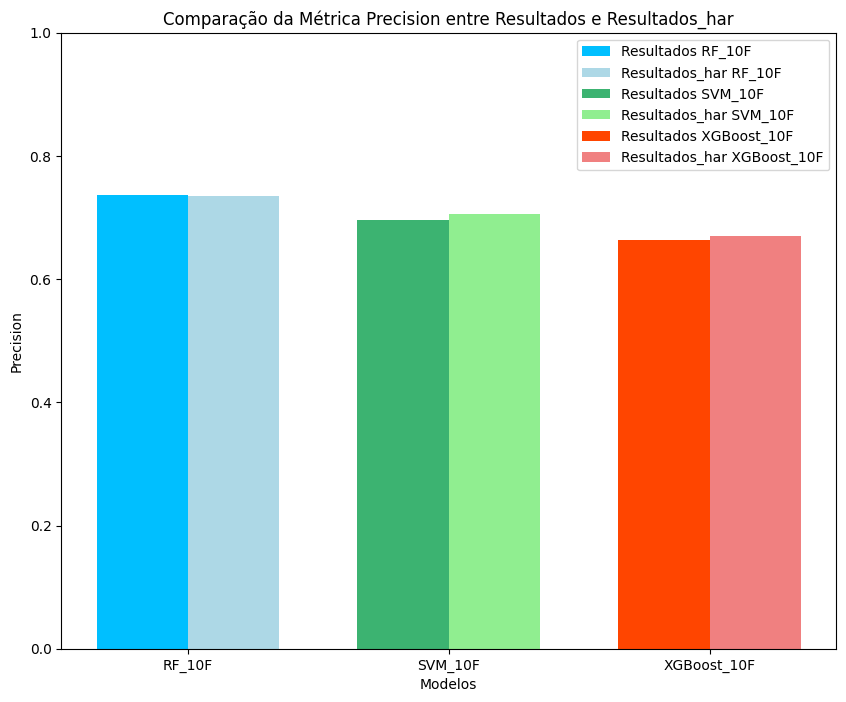

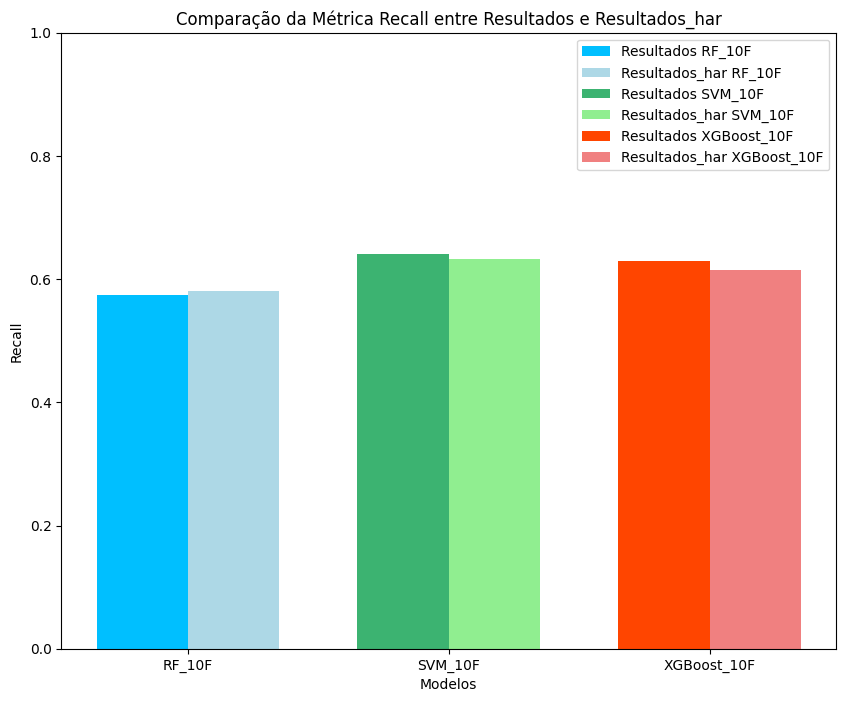

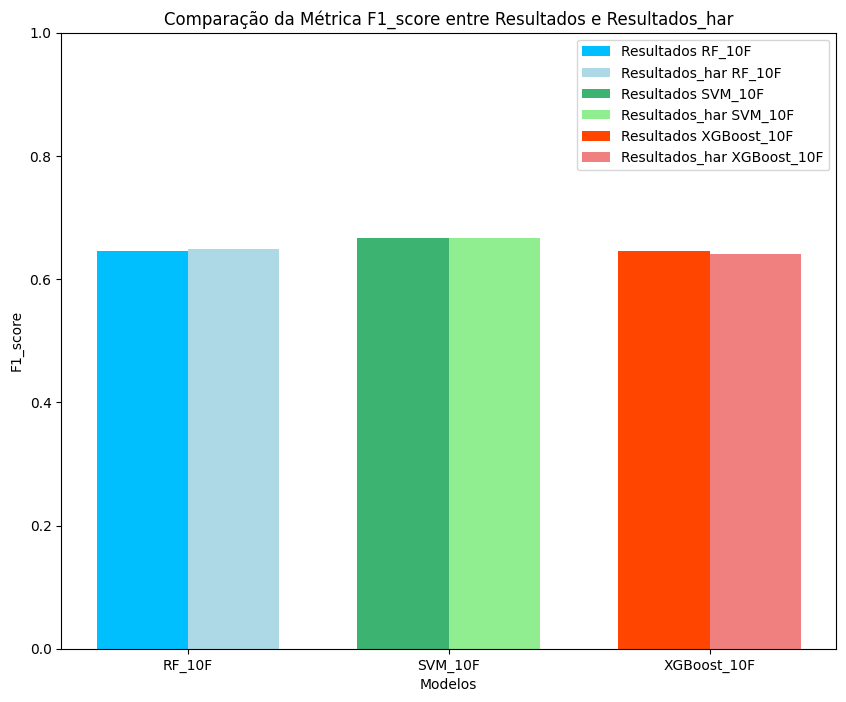

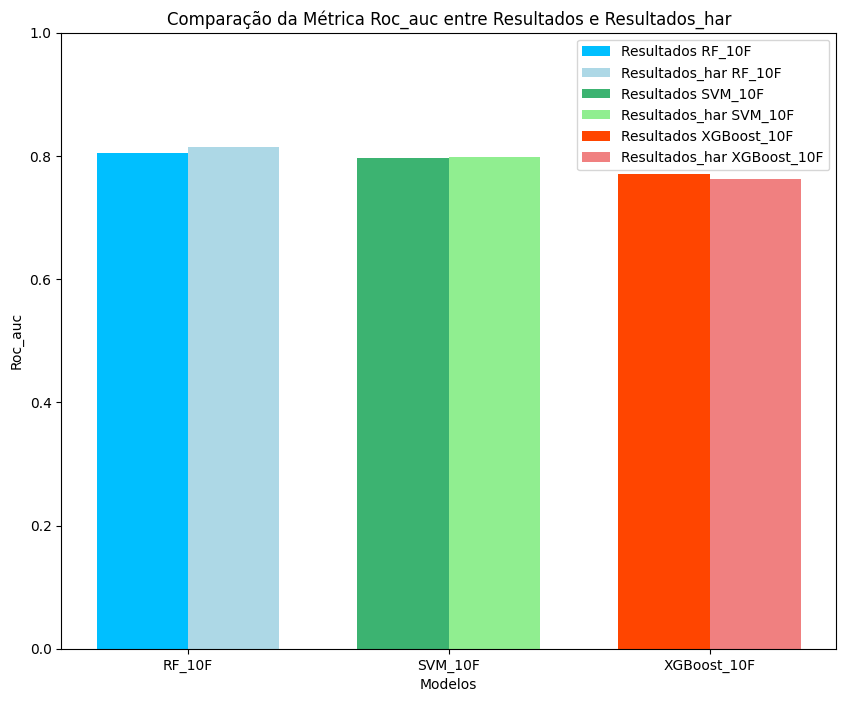

In [ ]:
filtered_results = {model: metrics for model, metrics in resultados.items() if model.endswith('10F')}
filtered_results_har = {model: metrics for model, metrics in resultados_har.items() if model.endswith('10F')}
models = list(filtered_results.keys()) 
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

#Definindo as cores específicas para cada modelo
model_colors = {
    'RF_10F': ('deepskyblue', 'lightblue'),   
    'SVM_10F': ('mediumseagreen', 'lightgreen'),
    'XGBoost_10F': ('orangered', 'lightcoral')
}


for metric in metrics:
    plt.figure(figsize=(10, 8))
    
   
    values_resultados = [filtered_results[model][metric] for model in models]
    values_resultados_har = [filtered_results_har[model][metric] for model in models]
    
    #Configurar a posição das barras
    bar_width = 0.35
    index = np.arange(len(models))
    

    for i, model in enumerate(models):
        color_resultados, color_resultados_har = model_colors[model]
        
        #Barra para resultados
        plt.bar(index[i], values_resultados[i], bar_width, color=color_resultados, label=f'Resultados {model}')
        
        #Barra para resultados_har
        plt.bar(index[i] + bar_width, values_resultados_har[i], bar_width, color=color_resultados_har, label=f'Resultados_har {model}')
    
    #Configurações do gráfico
    plt.xlabel('Modelos')
    plt.ylabel(metric.capitalize())
    plt.title(f'Comparação da Métrica {metric.capitalize()} entre Resultados e Resultados_har')
    plt.xticks(index + bar_width / 2, models)
    plt.ylim(0, 1)  
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.show()


# Visualização dos Resultados em Tabela

Dataset Original

In [73]:
df = pd.DataFrame(resultados)
df.drop(df.columns[0], axis=1, inplace=True)
print(df)

             RF_10F   SVM_10F  XGBoost_10F
accuracy   0.727805  0.724200     0.702569
precision  0.736278  0.695357     0.663366
recall     0.574713  0.641588     0.630094
f1_score   0.645540  0.667391     0.646302
roc_auc    0.804447  0.796101     0.770424


Os resultados dos modelos Random Forest, SVM e XGBoost apresentam desempenhos comparáveis na classificação dos nódulos.

O Random Forest obteve a maior accuracy de 72.78% e uma ROC AUC de 0.8044, enquanto o SVM se destacou com um recall de 64.16%, indicando uma melhor identificação de casos positivos. 

Por outro lado, apesar do XGBoost apresentar uma menor accuracy, obteve um desempenho equilibrado nas métricas de precision e F1 Score. 

Dataset Harmonizado

In [74]:
df_har = pd.DataFrame(resultados_har)
df_har.drop(df_har.columns[0], axis=1, inplace=True)
print(df_har)

             RF_10F   SVM_10F  XGBoost_10F
accuracy   0.729157  0.727355     0.703019
precision  0.735450  0.705128     0.669318
recall     0.580982  0.632184     0.615465
f1_score   0.649154  0.666667     0.641263
roc_auc    0.813882  0.798477     0.762204


Os resultados dos modelos Random Forest, SVM e XGBoost são consistentes, com variações nas métricas que refletem as diferentes capacidades de cada um.

O Random Forest alcançou uma pontuação mais alta na accuracy e na ROC AUC, sugerindo um bom equilíbrio entre precisão e capacidade de separação.

O SVM apresentou o maior Recall e f1_score, refletindo um bom compromisso entre precisão e recall.

Por outro lado, XGBoost demonstrou uma boa capacidade de recall e uma performance equilibrada, o que o torna igualmente adequado.


# Análise do Impacto da Harmonização no Dataset com Teste de Wilcoxon

In [ ]:
from scipy.stats import wilcoxon

wilcoxon_results = {}

filtered_results = {model: metrics for model, metrics in resultados.items() if model.endswith('10F')}
filtered_results_har = {model: metrics for model, metrics in resultados_har.items() if model.endswith('10F')}


for metric in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']:

    original = [filtered_results[model][metric] for model in filtered_results]
    harmonized = [filtered_results_har[model][metric] for model in filtered_results_har]
    
    #Executa o teste de Wilcoxon
    stat, p_value = wilcoxon(original, harmonized)
    
    #Armazena os resultados
    wilcoxon_results[metric] = {'statistic': stat, 'p_value': p_value}


for metric, results in wilcoxon_results.items():
    print(f'Teste de Wilcoxon para {metric}: Estatística = {results["statistic"]}, p-valor = {results["p_value"]}')

Teste de Wilcoxon para accuracy: Estatística = 0.0, p-valor = 0.25
Teste de Wilcoxon para precision: Estatística = 1.0, p-valor = 0.5
Teste de Wilcoxon para recall: Estatística = 1.0, p-valor = 0.5
Teste de Wilcoxon para f1_score: Estatística = 2.0, p-valor = 0.75
Teste de Wilcoxon para roc_auc: Estatística = 2.0, p-valor = 0.75


**Análise comparativa entre o Dataset por Harmonizar e o Dataset Harmonizado**

Com base nos resultados do teste de Wilcoxon para as métricas de accuracy, precision, recall, f1_score e roc_auc, observamos que todos os p-valores estão acima do limiar típico de significância (0.05). Este resultado indica que não há evidências estatisticamente significativas para afirmar que a harmonização do dataset levou a melhorias consistentes nas métricas de desempenho dos modelos.

Por conseguinte, o dataset não harmonizado e o harmonizado apresentam desempenhos estatisticamente semelhantes na identificação correta de nódulos benignos e malignos, o que pode justificar a utilização do dataset original sem que haja uma perda de eficácia. Assim, para a análise de resultados vamos utilizar as métricas obtidas através do dataset original.

# Análise de Resultados

O objetivo do nosso projeto é resolver o melhor possível o problema de classificação de nódulos em malignos e benignos. 
Por isso, o nosso critério para escolher o modelo com o melhor desempenho será o que obtiver o melhor resultado na correta classificação das labels e o que conseguir minimizar melhor os falsos negativos. 

**Análise das Métricas em Contexto Médico**

**F1-Score:** Em diagnósticos médicos, onde tanto os falsos positivos (que levam a exames desnecessários) quanto os falsos negativos (não deteção de casos malignos) têm custos significativos. Um F1-Score alto indica que o modelo equilibra bem a deteção correta de casos positivos com a minimização de alarmes falsos.

**Precisão (Precision):** Como os falsos positivos podem levar a exames ou tratamentos desnecessários em pacientes saudáveis, uma alta precisão é desejável para evitar procedimentos médicos injustificados.

**Sensibilidade (Recall):** Em diagnósticos de condições graves como o cancro, o recall é crucial para minimizar a ocorrência de falsos negativos, assegurando que a maioria dos casos malignos seja corretamente identificada.

**Acurácia (Accuracy):** A accuracy é útil para uma visão geral do modelo, mas pode ser enganadora em dados desbalanceados, onde um bom desempenho numa das classes pode mascarar problemas na outra.

**AUC (Área sob a Curva ROC):** A AUC ajuda a entender o desempenho geral do modelo em diferentes limiares de classificação, oferecendo flexibilidade para ajustar o equilíbrio entre sensibilidade e especificidade. Uma AUC alta permite maximizar a deteção de casos malignos, minimizando falsos positivos.

Assim, apesar de todas as métricas serem importantes, no contexto do nosso problema, as que consideramos mais informativas são o F1-Score, o Recall e a AUC.


**O F1-Score nos nossos modelos apresenta os seguinte valores:**
> RF_10F ------- 0.6455

> SVM_10F ------ 0.6674 

> XGBoost_10F -- 0.6463


**A Recall nos nossos modelos apresenta os seguinte valores:**
> RF_10F ------- 0.5747

> SVM_10F ------ 0.6416

> XGBoost_10F -- 0.6301


**A AUC nos nossos modelos apresenta os seguinte valores:**
> RF_10F ------- 0.8044

> SVM_10F ------ 0.7961

> XGBoost_10F -- 0.7704


# Conclusões

Com base na análise de resultados que realizamos anteriormente, concluimos que o modelo que obteve o melhor desempenho, no contexto do problema, é o SVM. E por isso consideramos que seria o mais adequado para prever a malignidade dos nódulos pulmonares.

O seu valor de Recall é o mais alto entre os modelos implementados, o que indica que o SVM é o melhor a identificar corretamente uma maior proporção dos nódulos de interesse, reduzindo o risco de falsos negativos no contexto da previsão de malignidade

O seu valor de F1-Score é o mais alto entre os modelos implementados, o que indica que o SVM é o melhor a equilibrar precision e recall, proporcionando um desempenho mais consistente na identificação correta dos nódulos, minimizando tanto os falsos positivos quanto os falsos negativos.

Quando comparado com o Random Forest o seu valor de AUC é ligeiramente inferior. No entanto, como a diferença não é muito significativa consideramos que quando em conjunto com as restantes métricas o SVM é o modelo que melhor resolve o nosso problema.